#                   EMG WORD LEVEL MODEL DEVELOPMENT

In [185]:
# import necessary modules
import os
import pickle
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import tqdm
import pprint
import sys

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
import matplotlib as mlp
import matplotlib.pyplot as plt
mlp.rc("xtick",labelsize=12)
mlp.rc("ytick",labelsize=12)
mlp.rc("axes",labelsize=14)

plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['figure.dpi'] = 100


import librosa
import librosa.display

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.decomposition import FastICA
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

import tensorflow as tf
from tensorflow import keras


# a function to save plotted figures
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(MAIN_DIR, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# a function to save trained models as pickle object
def save_model(name,model,extension=".pickle"):
    path = os.path.join(MODEL_PATH,name+extension)
    print("Saving Model : ",name)
    file = open(path,"wb")
    pickle.dump(model,file)
    file.close()

In [2]:
# necessary definitions

MAIN_DIR = "/home/deadpool/Kaggle Projects/EMG Tanja Ma'am/"
os.chdir(MAIN_DIR)

AUDIBLE = os.path.join("TOP_WORDS","audible")
WHISPERED = os.path.join("TOP_WORDS","whispered")
SILENT = os.path.join("TOP_WORDS","silent")

MODEL_PATH = ""

MODES = [AUDIBLE, WHISPERED, SILENT]

SR_AUDIO = 16000 # in Hz
SR_EMG = 600 # in Hz

FRAME_SIZE = 27 # in milliseconds
FRAME_SHIFT = 10 # in milliseconds

FRAME_SAMPLES = int((FRAME_SIZE/1000)*SR_EMG)
PER_FRAME_SAMPLES = int((FRAME_SHIFT/1000)*SR_EMG)

print("Samples in a frame: ",FRAME_SAMPLES)
print("Samples shift per frame: ",PER_FRAME_SAMPLES)

Samples in a frame:  16
Samples shift per frame:  6


## IMPORTING DATASET

In [3]:
top_10_words = ["THE","A","TO","OF","IN","ARE","AND","IS","THEY","THAT"]
top_20_words = top_10_words + ["THIS","AN","HAS","HE","I","ON","WERE","IT","WE","YOU"]

# for top 10 words
audio_file = "Top10_Audio.pickle"
emg_file = "Top10_EMG.pickle"

# for top 20 words
# audio_file = "Top20_Audio.pickle"
# emg_file = "Top20_EMG.pickle"

# AUDIBLE MODE FILES
audible_audio = pickle.load(open(os.path.join(AUDIBLE,audio_file),"rb"))
audible_emg = pickle.load(open(os.path.join(AUDIBLE,emg_file),"rb"))

# WHISPERED MODE FILES
whispered_audio = pickle.load(open(os.path.join(WHISPERED,audio_file),"rb"))
whispered_emg = pickle.load(open(os.path.join(WHISPERED,emg_file),"rb"))

# SILENT MODE FILES
silent_audio = pickle.load(open(os.path.join(SILENT,audio_file),"rb"))
silent_emg = pickle.load(open(os.path.join(SILENT,emg_file),"rb"))

LABELS = list(audible_audio.keys())
LABELS.sort()
print("LABELS: ",LABELS)

LABELS:  ['A', 'AND', 'ARE', 'IN', 'IS', 'OF', 'THAT', 'THE', 'THEY', 'TO']


In [4]:
# parsing dataset into lists

X_audible_emg = []
Y_audible_emg = []

X_whispered_emg = []
Y_whispered_emg = []

X_silent_emg = []
Y_silent_emg = []

for keys in list(audible_emg.keys()):
    X_audible_emg.extend(audible_emg[keys])
    Y_audible_emg.extend([keys] * len(audible_emg[keys]))
    
    X_whispered_emg.extend(whispered_emg[keys])
    Y_whispered_emg.extend([keys] * len(whispered_emg[keys]))

    X_silent_emg.extend(silent_emg[keys])
    Y_silent_emg.extend([keys] * len(silent_emg[keys]))
        

# first convert ADC values to Voltages (0.033 uV)

X_audible_emg = np.array(X_audible_emg) * 0.033
Y_audible_emg = np.array(Y_audible_emg)

X_whispered_emg = np.array(X_whispered_emg) * 0.033
Y_whispered_emg = np.array(Y_whispered_emg)

X_silent_emg = np.array(X_silent_emg) * 0.033
Y_silent_emg = np.array(Y_silent_emg)
        
        
print("AUDIO MODE FILES")
print("X :",(X_audible_emg.shape))
print("Y :",(Y_audible_emg.shape))

print("WHISPERED MODE FILES")
print("X :",(X_whispered_emg.shape))
print("Y :",(Y_whispered_emg.shape))

print("SILENT MODE FILES")
print("X :",(X_silent_emg.shape))
print("Y :",(Y_silent_emg.shape))


AUDIO MODE FILES
X : (2142, 6)
Y : (2142,)
WHISPERED MODE FILES
X : (563, 6)
Y : (563,)
SILENT MODE FILES
X : (561, 6)
Y : (561,)


## VISUALING DATASET

In [266]:
# play the LABEL Words
from sounddevice import play
from time import sleep

for keys in list(audible_audio.keys()):
    play(audible_audio[keys][20],SR_AUDIO)
    print("Playing :", keys)
    sleep(1)

Playing : THE
Playing : A
Playing : TO
Playing : OF
Playing : IN
Playing : ARE
Playing : AND
Playing : IS
Playing : THEY
Playing : THAT


In [6]:
# verify the audio and the emg are synchronized 
print("Length of audio file: {} seconds".format(len(audible_audio["THAT"][0])/SR_AUDIO))
print("Length of emg file: {} seconds".format(len((audible_emg["THAT"][0])[0])/SR_EMG))

Length of audio file: 0.19 seconds
Length of emg file: 0.19 seconds


### Check Distribution of Data

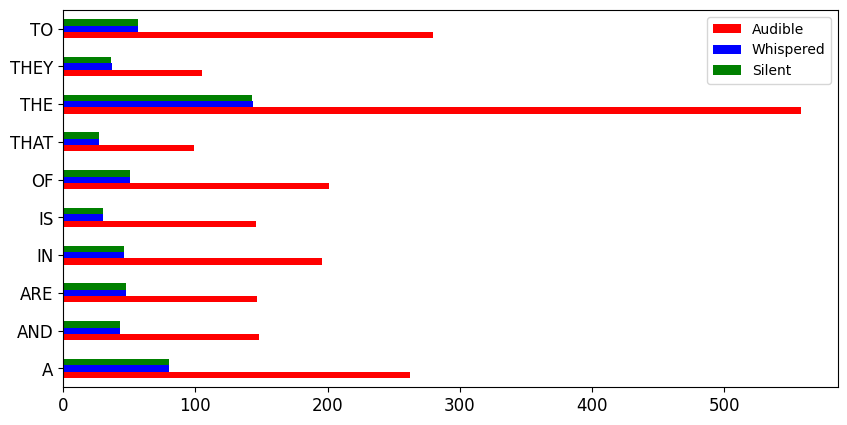

In [7]:
labels = pd.DataFrame({"Audible":(pd.Series(Y_audible_emg)).value_counts(),"Whispered":(pd.Series(Y_whispered_emg)).value_counts(),"Silent":(pd.Series(Y_silent_emg)).value_counts()})
# labels["Audible"].plot(kind="barh",alpha=0.2,color="blue")
# labels["Whispered"].plot(kind="barh",alpha=0.3,color="orange")
# labels["Silent"].plot(kind="barh",alpha=0.2,color="red")

labels.plot(kind="barh",rot=0,color={"blue","green","red"})

In [8]:
# labels = pd.Series(Y_audible_emg)
# plt.title("Audible Mode")
# plt.xlabel("Counts")
# plt.ylabel("Labels")
# labels.value_counts().plot(kind="barh")

In [9]:
# labels = pd.Series(Y_whispered_emg)
# plt.title("Whispered Mode")
# plt.xlabel("Counts")
# plt.ylabel("Labels")
# labels.value_counts().plot.bar()#(kind="barh")

In [10]:
# labels = pd.Series(Y_silent_emg)
# print(labels.value_counts())
# plt.title("Silent Mode")
# plt.xlabel("Counts")
# plt.ylabel("Labels")
# labels.value_counts().plot(kind="barh")

(-135.95000000000002, 2854.95, -36044.75, 36043.75)

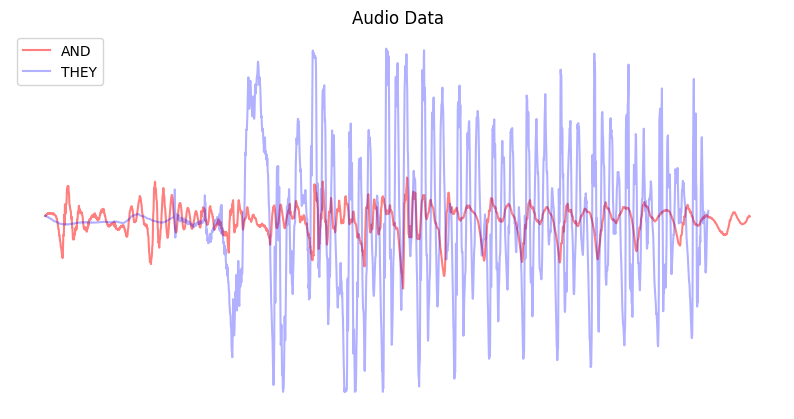

In [11]:
plt.title("Audio Data")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.plot(audible_audio["AND"][20],"r",alpha=0.5)
plt.plot(audible_audio["THEY"][20],"b",alpha=0.3)
plt.legend(["AND","THEY"],loc="upper left")
plt.axis("off")

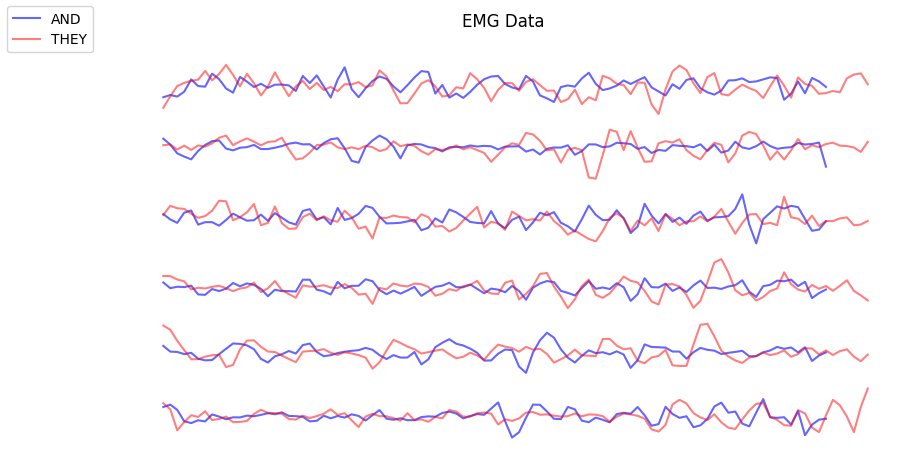

In [12]:
fig,axes = plt.subplots(nrows=6,ncols=1)
fig.suptitle('EMG Data')
for ax,channel in zip(axes.flat,range(6)):
    ax.plot((audible_emg["THEY"][20])[channel],"b",alpha=0.6)
    ax.plot((audible_emg["AND"][20])[channel],"r",alpha=0.5)
    ax.axis("off")

fig.legend(["AND","THEY"],loc="upper left")

## PREPROCESSING DATA

### Analysing Data

(array([163., 229., 119.,  36.,   9.,   4.,   0.,   0.,   0.,   1.]),
 array([ 24.,  75., 126., 177., 228., 279., 330., 381., 432., 483., 534.]),
 <a list of 10 Patch objects>)

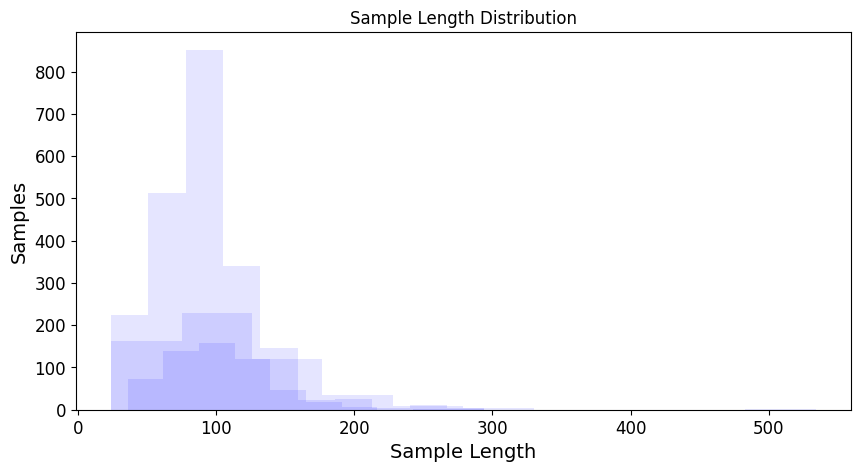

In [13]:
plt.title("Sample Length Distribution")
plt.xlabel("Sample Length")
plt.ylabel("Samples")
plt.hist([len((x[0])) for x in X_audible_emg],color="b",alpha=0.1)
plt.hist([len((x[0])) for x in X_whispered_emg],color="b",alpha=0.1)
plt.hist([len((x[0])) for x in X_silent_emg],color="blue",alpha=0.1)

In [14]:
perc = 95
length_95_perc = []
length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_audible_emg], perc)))]
print(f"The {perc}% of the Audible data has length lower or equal to {length_95_perc[0]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_whispered_emg], perc)))]
print(f"The {perc}% of the Whispered data has length lower or equal to {length_95_perc[1]}.")

length_95_perc = length_95_perc + [int(np.ceil(np.percentile([len((x[0])) for x in X_silent_emg], perc)))]
print(f"The {perc}% of the Silent data has length lower or equal to {length_95_perc[2]}.")

The 95% of the Audible data has length lower or equal to 144.
The 95% of the Whispered data has length lower or equal to 162.
The 95% of the Silent data has length lower or equal to 198.


In [15]:
# Trimming the data

for x in range(len(X_audible_emg)):
    for channel in range(6):
        X_audible_emg[x][channel] = X_audible_emg[x][channel][:length_95_perc[0]]
        
for x in range(len(X_whispered_emg)):
    for channel in range(6):        
        X_whispered_emg[x][channel] = X_whispered_emg[x][channel][:length_95_perc[1]] 
        
for x in range(len(X_silent_emg)):
    for channel in range(6):        
        X_silent_emg[x][channel] = X_silent_emg[x][channel][:length_95_perc[2]] 

(array([ 18.,  80.,  65., 100.,  84.,  62.,  50.,  31.,  31.,  40.]),
 array([ 24. ,  41.4,  58.8,  76.2,  93.6, 111. , 128.4, 145.8, 163.2,
        180.6, 198. ]),
 <a list of 10 Patch objects>)

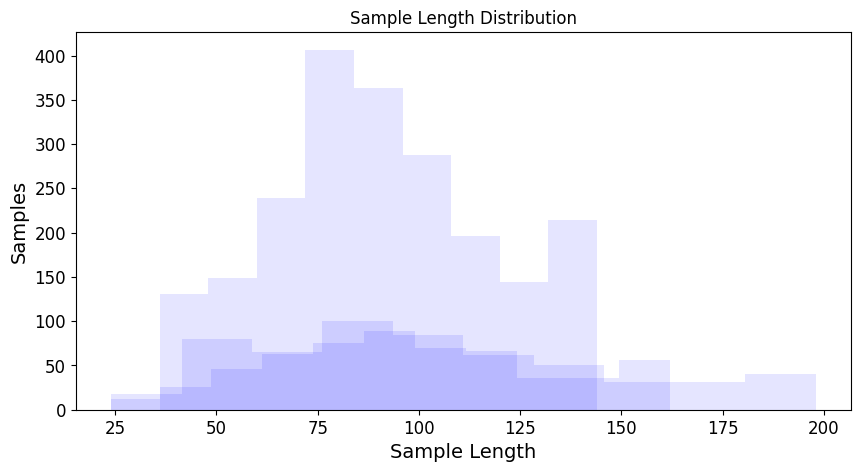

In [16]:
plt.title("Sample Length Distribution")
plt.xlabel("Sample Length")
plt.ylabel("Samples")
plt.hist([len((x[0])) for x in X_audible_emg],color="b",alpha=0.1)
plt.hist([len((x[0])) for x in X_whispered_emg],color="b",alpha=0.1)
plt.hist([len((x[0])) for x in X_silent_emg],color="blue",alpha=0.1)

### Scaling the data

In [142]:
# scaling the data

# saves stats for later use in model implementation



# from scipy.stats import zscore

# for x in range(len(X_audible_emg)):
#     for channel in range(6):
#         X_audible_emg[x][channel] = zscore(X_audible_emg[x][channel])
        
# for x in range(len(X_whispered_emg)):
#     for channel in range(6):        
#         X_whispered_emg[x][channel] = zscore(X_whispered_emg[x][channel]) 
        
# for x in range(len(X_silent_emg)):
#     for channel in range(6):        
#         X_silent_emg[x][channel] = zscore(X_silent_emg[x][channel])

### Zero Padding the data

In [17]:

for x in range(len(X_audible_emg)):
    for channel in range(6):
        X_audible_emg[x][channel] = np.pad(X_audible_emg[x][channel],(0,length_95_perc[0]-len(X_audible_emg[x][channel])),constant_values=(0.0,0.0))
        
for x in range(len(X_whispered_emg)):
    for channel in range(6):        
        X_whispered_emg[x][channel] = np.pad(X_whispered_emg[x][channel],(0,length_95_perc[1]-len(X_whispered_emg[x][channel])),constant_values=(0.0,0.0))
        
for x in range(len(X_silent_emg)):
    for channel in range(6):        
        X_silent_emg[x][channel] = np.pad(X_silent_emg[x][channel],(0,length_95_perc[2]-len(X_silent_emg[x][channel])),constant_values=(0.0,0.0))
        

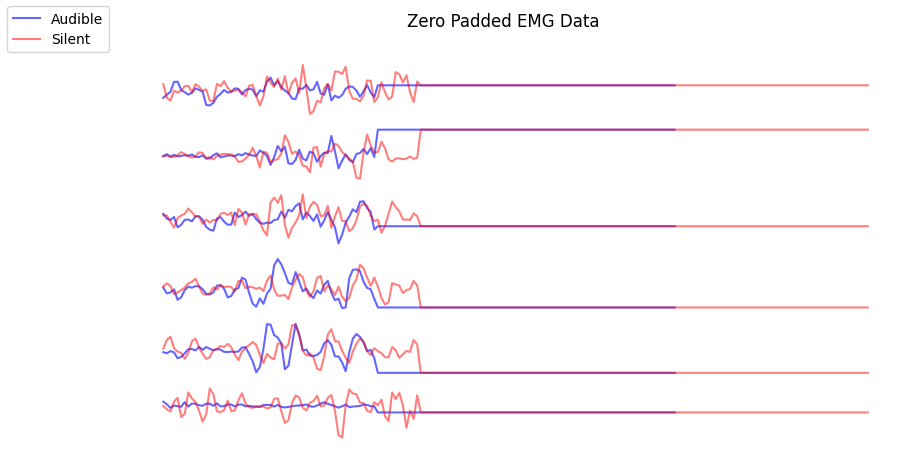

In [18]:
fig,axes = plt.subplots(nrows=6,ncols=1)
fig.suptitle('Zero Padded EMG Data')
for ax,channel in zip(axes.flat,range(6)):
    ax.plot((X_audible_emg[0])[channel],"b",alpha=0.6)
    ax.plot((X_silent_emg[0])[channel],"r",alpha=0.5)
    ax.axis("off")

fig.legend(["Audible","Silent"],loc="upper left")

## FEATURE EXTRACTION

### Defining Feature Class

In [29]:
class EMG(object):
    """
    preprocessing and feature extraction class for EMG data
    X = List of all instances of input data
    x = an instance of the input data 
    Y = List of all instances of input labels
    y = an instance of the input label
    
    average length of a word utterance: ( 600ms(100 wpm) + 480ms (130 wpm) + 360ms (160 wpm) ) / 3 =  480ms
    """
    
    def __init__(self, SR,FRAME_SIZE,FRAME_SHIFT,MODE):
        """Set the variables """
        self.SR = SR
        self.FRAME_SIZE = FRAME_SIZE
        self.FRAME_SHIFT = FRAME_SHIFT
        self.MODE = MODE
        self.pickle_name = "X_"+MODE+"(features).pickle"
        
        
    def reduce_dimension(self,X,feature_len=200,type="PCA"): 
        if type=="PCA":
            pca = PCA(n_components=feature_len)
            temp_X = pca.fit_transform(X)
        
        elif type=="ICA":
            ica = FastICA(n_components=feature_len)
            temp_X = pca.fit_transform(X)
       
        print("New Dimension of Data: ",temp_X.shape)
        return temp_X
    
    
    def encode_labels(self,Y):
        """Encodes the labels"""
        encoder = LabelEncoder()
        return encoder.fit_transform(Y)


    def DNPA(self,seg):
        """Double Nine Point Average"""
        w = []
        for i in range(len(seg)):
            a = i - 4
            b = i + 4
            a = a if a>=0 else 0
            b = b if b<len(seg) else len(seg)
            w.append(int(np.sum(seg[a:b])/9))

        v = []
        for i in range(len(seg)):
            a = i - 4
            b = i + 4
            a = a if a>=0 else 0
            b = b if b<len(seg) else len(seg)
            v.append(int(np.sum(w[a:b])/9))

        return v

    
    def ZCR(self,seg):
        """Zero Crossing Rate"""
        pos = seg>0
        npos = ~pos
        return len(((pos[:-1] & npos[1:]) | (npos[:-1] & pos[1:])).nonzero()[0])

    
    def HFS(self,seg):
        """High frequency signals"""
        return np.subtract(seg,self.DNPA(seg))

    
    def RHFS(self,seg):
        """Rectified High frequency signals"""
        return abs(self.HFS(seg))

    
    def FBP(self,seg):
        """Frame Based Power"""
        return np.sum(np.power(seg,2))

    
    def feature(self,seg,type="time"):
        """ 
        "time": Features in time domain
        "freq": Features in frequency domain
        "all": Features in both domain
        """
        if type == "time":
            return np.hstack((self.DNPA(seg),self.RHFS(seg),self.HFS(seg),self.ZCR(seg),self.FBP(seg)))
        elif type == "freq":
            return 
        elif type == "all":
            return np.hstack(self.feature(seg,"time"),self.feature(seg,"freq"))

    
    def MFCC(self,seg):
        """Mel Frequency Cepstral Coefficients"""
        mfcc = librosa.feature.mfcc(y=seg,sr=self.SR,n_mfcc=20)
#         return np.mean(mfcc.T,axis=0)
        return mfcc

    
    def STFT(self,seg):
        """Short Time Fourier Transform"""
        stft = librosa.feature.chroma_stft(y=seg,sr=self.SR,n_fft=20)
#         return np.mean(stft.T,axis=0)
        return stft

    
    def segment(self,x):
        """Segmenting the data into frames and sliding them according to the frame shift"""
        f = []
        for channel in range(6):
            for i in range(len(x[0])):
                a = i*self.FRAME_SHIFT
                b = a + self.FRAME_SIZE
                if(b>len(x[0])):
                    break
                seg = x[channel][a:b]
                f.extend(self.feature(seg))
        return f

    def fit(self,X,Y):
        """Extract Features and return the zero padded list of features"""
        if(self.pickle_name in os.listdir() ):
            print("Fetching Pickle file")
            temp_X = pickle.load(open(self.pickle_name,"rb"))
        else:
            temp_X = []
            for x,count in zip(X, tqdm.tqdm(range(len(X)),ncols=100,desc="Extracting Features("+self.MODE+")" ) ):
                temp_X.append(self.segment(x))

            # save all extracted features to a pickle file
            print("Saving features as: ",self.pickle_name)
            pickle.dump(temp_X,open(self.pickle_name,"wb"))
        temp_X = np.array(temp_X)
        print(len(temp_X))
        print(len(Y))
        print(temp_X.shape)
        return self.reduce_dimension(temp_X),self.encode_labels(Y)

    def fit_transform(self,X,Y):
        return self.fit(X,Y)


In [30]:
audible_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="audible")

X_audible, Y_audible = audible_EMG.fit_transform(X_audible_emg,Y_audible_emg)

Fetching Pickle file
2142
2142
(2142, 6600)
New Dimension of Data:  (2142, 200)


In [31]:
whisper_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="whispered")

X_whisper, Y_whisper = whisper_EMG.fit_transform(X_whispered_emg,Y_whispered_emg)

Fetching Pickle file
563
563
(563, 7500)
New Dimension of Data:  (563, 200)


In [32]:
silent_EMG = EMG(SR_EMG,FRAME_SAMPLES,PER_FRAME_SAMPLES,MODE="silent")

X_silent, Y_silent = silent_EMG.fit_transform(X_silent_emg,Y_silent_emg)

Fetching Pickle file
561
561
(561, 9300)
New Dimension of Data:  (561, 200)


### Reducing Feature Dimensions

    length of a phones considered as 30ms(~27ms)
    3 frames per phoneme
    3-5 phonemes per word
    ideal feature length = ( (frame_size * 3 * 5 + frame_size * 3 * 3) /2 ) * SR = 194(~200)


### Train Test Split

In [178]:
def train_test_split(X_new,Y_new):
    split = StratifiedShuffleSplit(n_splits=1, test_size =0.1, random_state=42)
    train_id, test_id = next(split.split(X_new,Y_new))
    print("Train Set Shape: ",X_new[train_id].shape)
    print("Test Set Shape: ",X_new[test_id].shape)
    return X_new[train_id], Y_new[train_id], X_new[test_id], Y_new[test_id]

In [179]:
X_audible_train, Y_audible_train , X_audible_test, Y_audible_test = train_test_split(X_audible,Y_audible)

Train Set Shape:  (1927, 200)
Test Set Shape:  (215, 200)


In [180]:
X_whisper_train, Y_whisper_train , X_whisper_test, Y_whisper_test = train_test_split(X_whisper,Y_whisper)

Train Set Shape:  (506, 200)
Test Set Shape:  (57, 200)


In [181]:
X_silent_train, Y_silent_train , X_silent_test, Y_silent_test = train_test_split(X_silent,Y_silent)

Train Set Shape:  (504, 200)
Test Set Shape:  (57, 200)


## MACHINE LEARNING MODELS

### KNN Classifier

In [274]:
def KNN_Classifier(X_train,y_train,X_test,y_test):
    KNN_model = KNeighborsClassifier(n_neighbors=8, weights="uniform")
    KNN_model.fit(X_train,y_train)
    KNN_prediction = KNN_model.predict(X_train)
    KNN_accuracy = accuracy_score(y_train,KNN_prediction)
    print("  KNN ACCURACY (Train): ",KNN_accuracy)
    print("  KNN ACCURACY (Test): ",accuracy_score(y_test,KNN_model.predict(X_test)))
    print(classification_report(y_train,KNN_prediction,target_names=LABELS))

    plt.matshow(confusion_matrix(y_train,KNN_prediction,normalize="true"),cmap="gray")
    plt.xticks(range(0,10),LABELS)
    plt.yticks(range(0,10),LABELS)
    plt.show()
#     return KNN_accuracy,accuracy_score(y_test,KNN_model.predict(X_test))
#     return accuracy_score(y_test,KNN_model.predict(X_test))


### SVM Classifier

In [59]:
def SVM_Classifier(X_train,y_train,X_test,y_test):
    SVM_model = SVC(verbose=0)
    SVM_model.fit(X_train,y_train)
    SVM_prediction = SVM_model.predict(X_train)
    SVM_accuracy = accuracy_score(y_train,SVM_prediction)
#     print("SVM ACCURACY (Train): ",SVM_accuracy)
#     print("SVM ACCURACY (Test): ",accuracy_score(y_test,SVM_model.predict(X_test)))
#     print(classification_report(y_train,SVM_prediction,target_names=LABELS))

#     plt.matshow(confusion_matrix(y_train,SVM_prediction,normalize="true"),cmap="gray")
#     plt.xticks(range(0,10),LABELS)
#     plt.yticks(range(0,10),LABELS)
#     plt.show()
    return SVM_accuracy, accuracy_score(y_test,SVM_model.predict(X_test))


### Multilayer Perceptron

In [276]:
def MLP_Classifier(X_train,y_train,X_test,y_test):
    
#     y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
#     y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)
    MLP_model = keras.Sequential()
    MLP_model.add(keras.layers.Dense(activation="relu",input_shape=X_train[0].shape,units=len(X_train[0])))
    MLP_model.add(keras.layers.Dropout(0.2))
    MLP_model.add(keras.layers.Dense(100,activation="relu"))
#     MLP_model.add(keras.layers.Dropout(0.1))
#     MLP_model.add(keras.layers.Dense(64,activation="relu"))
#     MLP_model.add(keras.layers.Dropout(0.1))
    MLP_model.add(keras.layers.Dense(32,activation="relu"))
    MLP_model.add(keras.layers.Dense(10,activation="softmax"))

    loss = keras.losses.SparseCategoricalCrossentropy()
#     loss = keras.losses.CategoricalCrossentropy()
    opt = keras.optimizers.Adam(lr=0.00002)
#     opt = keras.optimizers.Adam()
    MLP_model.compile(optimizer=opt,loss=loss,metrics=["accuracy"])
#     print(MLP_model.summary())
    history = MLP_model.fit(X_train,y_train,epochs=200,verbose=1,batch_size=50)
    max_val_acc = max(history.history['accuracy'])
    print(max_val_acc)
#     print(MLP_model.evaluate(X_test,y_test)[1])
    
#     MLP_prediction = MLP_model.predict_classes(X_train)
#     MLP_accuracy = accuracy_score(y_train,MLP_prediction)
#     print("MLP ACCURACY (Train): ",MLP_accuracy)
    # print("MLP ACCURACY (Test): ",accuracy_score(y_test,MLP_model.predict_classes(X_test)))
    # print(classification_report(y_train,MLP_prediction,target_names=LABELS))
    # plt.matshow(confusion_matrix(y_train,MLP_prediction,normalize="true"),cmap="gray")
    # plt.xticks(range(0,10),LABELS)
    # plt.yticks(range(0,10),LABELS)
#     plt.show(history.history(["accuracy"]))
#     plt.show()
#     return MLP_accuracy, accuracy_score(y_test,MLP_model.predict_classes(X_test))

    return MLP_model.evaluate(X_test,y_test)[1]
#     return history.history['accuracy']

### 1D CNN Classifier

In [262]:
def CNN_Classifier(X_train,y_train,X_test,y_test):
    
    y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
    y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)
    CNN_model = keras.Sequential()
    CNN_model.add(keras.layers.Conv1D(100,kernel_size=3,input_shape=(len(X_train[0]),1),activation="relu"))
    CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
    CNN_model.add(keras.layers.Conv1D(100,kernel_size=3,activation="relu"))
    CNN_model.add(keras.layers.MaxPool1D(pool_size=2))
    CNN_model.add(keras.layers.Flatten())
    CNN_model.add(keras.layers.Dense(100,activation="relu"))
    CNN_model.add(keras.layers.Dense(10,activation="softmax"))

    loss = keras.losses.CategoricalCrossentropy() 
    opt = keras.optimizers.Adam(lr=0.00001)

    CNN_model.compile(optimizer=opt,loss=loss,metrics=['accuracy'])
#     print(CNN_model.summary())

    X_train = X_train.reshape(len(X_train),len(X_train[0]),1)
    X_test = X_test.reshape(len(X_test),len(X_test[0]),1)
    history = CNN_model.fit(X_train,y_train,epochs=200,batch_size=50,verbose=0)

    CNN_prediction = CNN_model.predict_classes(X_train)
    max_val_acc = max(history.history['accuracy'])
    print(max_val_acc)
#     print("Test Accuracy",CNN_model.evaluate(X_test,y_test)[0])
#     CNN_accuracy = accuracy_score(y_train,CNN_prediction)
#     print("CNN ACCURACY (Train): ",CNN_accuracy)
#     print("CNN ACCURACY (Test): ",accuracy_score(y_test,CNN_model.predict_classes(X_test)))
#     plt.matshow(confusion_matrix(y_train,CNN_prediction,normalize="true"),cmap="gray")
#     plt.xticks(range(0,10),LABELS)
#     plt.yticks(range(0,10),LABELS)

#     return CNN_accuracy, accuracy_score(y_test,CNN_model.predict_classes(X_test))
    return CNN_model.evaluate(X_test,y_test)[1]


## TRAINING MODELS

In [277]:
# print("KNN :",KNN_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test))
# print("SVM :",SVM_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test))
print("MLP :",MLP_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test))
# print("CNN :",CNN_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test))

Epoch 1/200
39/39 [==============================] - 0s 7ms/step - loss: 304753.4062 - accuracy: 0.0991
Epoch 2/200
39/39 [==============================] - 0s 6ms/step - loss: 256041.8125 - accuracy: 0.1168
Epoch 3/200
39/39 [==============================] - 0s 6ms/step - loss: 222987.5156 - accuracy: 0.1297
Epoch 4/200
39/39 [==============================] - 0s 5ms/step - loss: 195707.1250 - accuracy: 0.1531
Epoch 5/200
39/39 [==============================] - 0s 5ms/step - loss: 179356.1250 - accuracy: 0.1562
Epoch 6/200
39/39 [==============================] - 0s 6ms/step - loss: 162573.5781 - accuracy: 0.1676
Epoch 7/200
39/39 [==============================] - 0s 7ms/step - loss: 151092.9844 - accuracy: 0.1785
Epoch 8/200
39/39 [==============================] - 0s 6ms/step - loss: 137679.6406 - accuracy: 0.1796
Epoch 9/200
39/39 [==============================] - 0s 6ms/step - loss: 133020.7969 - accuracy: 0.1832
Epoch 10/200
39/39 [==============================] - 0s 6ms/ste

39/39 [==============================] - 0s 6ms/step - loss: 2599.3235 - accuracy: 0.2662
Epoch 80/200
39/39 [==============================] - 0s 6ms/step - loss: 2131.7202 - accuracy: 0.2455
Epoch 81/200
39/39 [==============================] - 0s 6ms/step - loss: 2229.5376 - accuracy: 0.2657
Epoch 82/200
39/39 [==============================] - 0s 5ms/step - loss: 1725.1464 - accuracy: 0.2647
Epoch 83/200
39/39 [==============================] - 0s 6ms/step - loss: 1959.8949 - accuracy: 0.2496
Epoch 84/200
39/39 [==============================] - 0s 7ms/step - loss: 1918.6908 - accuracy: 0.2512
Epoch 85/200
39/39 [==============================] - 0s 6ms/step - loss: 1610.2242 - accuracy: 0.2657
Epoch 86/200
39/39 [==============================] - 0s 6ms/step - loss: 1506.1282 - accuracy: 0.2579
Epoch 87/200
39/39 [==============================] - 0s 6ms/step - loss: 1149.4076 - accuracy: 0.2506
Epoch 88/200
39/39 [==============================] - 0s 5ms/step - loss: 1326.0201 - 

39/39 [==============================] - 0s 6ms/step - loss: 107.6979 - accuracy: 0.2574
Epoch 159/200
39/39 [==============================] - 0s 6ms/step - loss: 61.8894 - accuracy: 0.2621
Epoch 160/200
39/39 [==============================] - 0s 6ms/step - loss: 49.8015 - accuracy: 0.2600
Epoch 161/200
39/39 [==============================] - 0s 6ms/step - loss: 69.9746 - accuracy: 0.2605
Epoch 162/200
39/39 [==============================] - 0s 6ms/step - loss: 22.7219 - accuracy: 0.2615
Epoch 163/200
39/39 [==============================] - 0s 6ms/step - loss: 48.1275 - accuracy: 0.2641
Epoch 164/200
39/39 [==============================] - 0s 6ms/step - loss: 103.7364 - accuracy: 0.2595
Epoch 165/200
39/39 [==============================] - 0s 7ms/step - loss: 77.1296 - accuracy: 0.2595
Epoch 166/200
39/39 [==============================] - 0s 7ms/step - loss: 60.2157 - accuracy: 0.2605
Epoch 167/200
39/39 [==============================] - 0s 6ms/step - loss: 75.5313 - accuracy:

In [106]:
print("KNN :",KNN_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test))
print("SVM :",SVM_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test))
print("MLP :",MLP_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test))
print("CNN :",CNN_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test))

KNN : (0.45454545454545453, 0.3157894736842105)
SVM : (0.4150197628458498, 0.3157894736842105)
0.4328063130378723
MLP : None
0.95652174949646
CNN : None


In [107]:
print("KNN :",KNN_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test))
print("SVM :",SVM_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test))
print("MLP :",MLP_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test))
print("CNN :",CNN_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test))

KNN : (0.39087301587301587, 0.15789473684210525)
SVM : (0.3472222222222222, 0.2982456140350877)
0.30158731341362
MLP : None
0.9047619104385376
CNN : None


In [191]:
# 10 Fold Cross Validation

def K_fold_CV(X_new,Y_new,K=10,):
    kfold = StratifiedKFold(n_splits=K,random_state=42)
    acc = []
    for train_id,test_id in kfold.split(X_new,Y_new):
#         acc.append(MLP_Classifier(X_new[train_id],Y_new[train_id],X_new[test_id],Y_new[test_id]))
        acc.append(CNN_Classifier(X_new[train_id],Y_new[train_id],X_new[test_id],Y_new[test_id]))
    return np.array(acc)

In [152]:
acc = K_fold_CV(X_audible,Y_audible)
print(acc)

0.9885832667350769
7/7 [==============================] - 0s 2ms/step - loss: 30306.8145 - accuracy: 0.3209
0.7270368337631226
7/7 [==============================] - 0s 3ms/step - loss: 5477.5884 - accuracy: 0.3349
0.9823651313781738
7/7 [==============================] - 0s 3ms/step - loss: 12382.9600 - accuracy: 0.4019
0.9683610200881958
7/7 [==============================] - 0s 3ms/step - loss: 12553.3682 - accuracy: 0.3505
0.9507261514663696
7/7 [==============================] - 0s 3ms/step - loss: 15111.8311 - accuracy: 0.3411
0.45072615146636963
7/7 [==============================] - 0s 2ms/step - loss: 271.5262 - accuracy: 0.2664
0.6296680569648743
7/7 [==============================] - 0s 4ms/step - loss: 3132.6633 - accuracy: 0.3131
0.976141095161438
7/7 [==============================] - 0s 2ms/step - loss: 7506.1313 - accuracy: 0.3037
0.7868257164955139
7/7 [==============================] - 0s 2ms/step - loss: 8309.6123 - accuracy: 0.4252
0.9870331883430481
7/7 [==========

In [156]:
print("Average :",acc.mean())
print("Max :",np.amax(acc))
print("Min :",np.amin(acc))

Average : 0.3426841974258423
Max : 0.4252336323261261
Min : 0.26635512709617615


In [157]:
acc = K_fold_CV(X_whisper,Y_whisper)
print(acc)

0.9940711259841919
2/2 [==============================] - 0s 2ms/step - loss: 54279.8594 - accuracy: 0.2632
0.9960474371910095
2/2 [==============================] - 0s 2ms/step - loss: 62150.1719 - accuracy: 0.2281
0.40316206216812134
2/2 [==============================] - 0s 2ms/step - loss: 8232.0664 - accuracy: 0.2982
0.9960552453994751
2/2 [==============================] - 0s 3ms/step - loss: 21472.8535 - accuracy: 0.2321
1.0
2/2 [==============================] - 0s 3ms/step - loss: 20459.3125 - accuracy: 0.1607
1.0
2/2 [==============================] - 0s 2ms/step - loss: 21705.6152 - accuracy: 0.1786
1.0
2/2 [==============================] - 0s 4ms/step - loss: 15982.1592 - accuracy: 0.2321
1.0
2/2 [==============================] - 0s 2ms/step - loss: 15550.6484 - accuracy: 0.2500
0.9921104311943054
2/2 [==============================] - 0s 8ms/step - loss: 21140.9258 - accuracy: 0.1786
0.9960552453994751
2/2 [==============================] - 0s 2ms/step - loss: 14461.8154

In [158]:
print("Average :",acc.mean())
print("Max :",np.amax(acc))
print("Min :",np.amin(acc))

Average : 0.2343045100569725
Max : 0.3214285671710968
Min : 0.1607142835855484


In [159]:
acc = K_fold_CV(X_silent,Y_silent)
print(acc)

0.9742063283920288
2/2 [==============================] - 0s 2ms/step - loss: 82190.9688 - accuracy: 0.2632
0.9702970385551453
2/2 [==============================] - 0s 4ms/step - loss: 53269.9727 - accuracy: 0.1964
0.5366336703300476
2/2 [==============================] - 0s 2ms/step - loss: 20475.3086 - accuracy: 0.1964
0.7148514986038208
2/2 [==============================] - 0s 2ms/step - loss: 10201.0850 - accuracy: 0.2679
0.8118811845779419
2/2 [==============================] - 0s 2ms/step - loss: 15324.6094 - accuracy: 0.0714
0.8574257493019104
2/2 [==============================] - 0s 5ms/step - loss: 9336.4590 - accuracy: 0.1607
0.7504950761795044
2/2 [==============================] - 0s 2ms/step - loss: 4762.0278 - accuracy: 0.3214
1.0
2/2 [==============================] - 0s 2ms/step - loss: 18990.4551 - accuracy: 0.1964
0.594059407711029
2/2 [==============================] - 0s 3ms/step - loss: 2829.0256 - accuracy: 0.1964
0.9782178401947021
2/2 [=======================

In [160]:
print("Average :",acc.mean())
print("Max :",np.amax(acc))
print("Min :",np.amin(acc))

Average : 0.21203007325530052
Max : 0.3214285671710968
Min : 0.0714285746216774


In [177]:
a = MLP_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test)
w = MLP_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test)
s = MLP_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test)

0.9922158718109131
0.992094874382019
0.9603174328804016


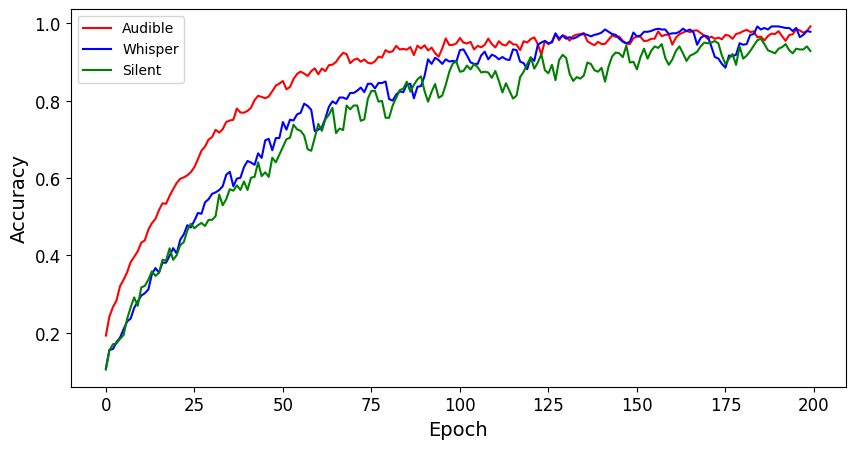

<Figure size 1000x500 with 0 Axes>

In [189]:
plt.plot(a,"r")
plt.plot(w,"b")
plt.plot(s,"g")
plt.legend(["Audible","Whisper","Silent"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()
# plt.savefig("MLP Accuracy")
plt.savefig("MLP Accuracy")

In [192]:
acc = K_fold_CV(X_audible,Y_audible)
print(acc)

0.993253767490387
7/7 [==============================] - 0s 12ms/step - loss: 8983.6357 - accuracy: 0.2837
0.9870264530181885
7/7 [==============================] - 0s 14ms/step - loss: 6728.4746 - accuracy: 0.3256
0.9942945837974548
7/7 [==============================] - 0s 10ms/step - loss: 6483.1567 - accuracy: 0.2664
0.9948132634162903
7/7 [==============================] - 0s 11ms/step - loss: 5955.0811 - accuracy: 0.3551
0.9885892271995544
7/7 [==============================] - 0s 12ms/step - loss: 4678.9673 - accuracy: 0.3364
0.9927386045455933
7/7 [==============================] - 0s 9ms/step - loss: 6290.9136 - accuracy: 0.2710
0.9942945837974548
7/7 [==============================] - 0s 13ms/step - loss: 3517.2886 - accuracy: 0.2850
0.9922199249267578
7/7 [==============================] - 0s 9ms/step - loss: 4062.0693 - accuracy: 0.3271
0.9911825656890869
7/7 [==============================] - 0s 11ms/step - loss: 3841.1150 - accuracy: 0.4019
0.9891079068183899
7/7 [=======

In [193]:
print("Average :",acc.mean())
print("Max :",np.amax(acc))
print("Min :",np.amin(acc))

Average : 0.32074331641197207
Max : 0.40186914801597595
Min : 0.26635512709617615


In [194]:
acc = K_fold_CV(X_whisper,Y_whisper)
print(acc)

0.9407114386558533
2/2 [==============================] - 0s 7ms/step - loss: 17700.5234 - accuracy: 0.1754
0.9683794379234314
2/2 [==============================] - 0s 7ms/step - loss: 15490.5781 - accuracy: 0.2281
0.9130434989929199
2/2 [==============================] - 0s 6ms/step - loss: 9776.9570 - accuracy: 0.2456
0.9546350836753845
2/2 [==============================] - 0s 6ms/step - loss: 7207.0825 - accuracy: 0.2321
0.9723865985870361
2/2 [==============================] - 0s 5ms/step - loss: 6137.8462 - accuracy: 0.1429
0.966469407081604
2/2 [==============================] - 0s 5ms/step - loss: 6405.5444 - accuracy: 0.2500
0.9881656765937805
2/2 [==============================] - 0s 10ms/step - loss: 5839.0127 - accuracy: 0.2500
0.9842209219932556
2/2 [==============================] - 0s 5ms/step - loss: 7856.9209 - accuracy: 0.2679
0.9644970297813416
2/2 [==============================] - 0s 8ms/step - loss: 8250.7666 - accuracy: 0.0893
0.9487179517745972
2/2 [===========

In [195]:
print("Average :",acc.mean())
print("Max :",np.amax(acc))
print("Min :",np.amin(acc))

Average : 0.20955513715744017
Max : 0.2678571343421936
Min : 0.0892857164144516


In [196]:
acc = K_fold_CV(X_silent,Y_silent)
print(acc)

0.817460298538208
2/2 [==============================] - 0s 7ms/step - loss: 15483.6621 - accuracy: 0.3860
0.8653465509414673
2/2 [==============================] - 0s 5ms/step - loss: 12895.5557 - accuracy: 0.1786
0.893069326877594
2/2 [==============================] - 0s 4ms/step - loss: 11171.9990 - accuracy: 0.2500
0.9049504995346069
2/2 [==============================] - 0s 4ms/step - loss: 9028.8506 - accuracy: 0.2143
0.8871287107467651
2/2 [==============================] - 0s 7ms/step - loss: 6536.4048 - accuracy: 0.1250
0.9168316721916199
2/2 [==============================] - 0s 6ms/step - loss: 6706.4678 - accuracy: 0.1250
0.8772277235984802
2/2 [==============================] - 0s 6ms/step - loss: 4885.0518 - accuracy: 0.1786
0.9227722883224487
2/2 [==============================] - 0s 6ms/step - loss: 4714.5220 - accuracy: 0.2679
0.8811880946159363
2/2 [==============================] - 0s 5ms/step - loss: 6844.8032 - accuracy: 0.1429
0.8871287107467651
2/2 [============

In [197]:
print("Average :",acc.mean())
print("Max :",np.amax(acc))
print("Min :",np.amin(acc))

Average : 0.20466791987419128
Max : 0.38596490025520325
Min : 0.125


In [ ]:
a = MLP_Classifier(X_audible_train,Y_audible_train,X_audible_test,Y_audible_test)
w = MLP_Classifier(X_whisper_train,Y_whisper_train,X_whisper_test,Y_whisper_test)
s = MLP_Classifier(X_silent_train,Y_silent_train,X_silent_test,Y_silent_test)